In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import hist
import pandas as pd
import uproot
import json
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep
from scipy import stats

In [2]:
fileset = {
    "flatZprime": [
        "/cms/akobert/NanoToolOutput/2017/flat/1587E0AD-27B9-3346-AFED-1CE7E1425016.root",
        "/cms/akobert/NanoToolOutput/2017/flat/37A8D520-A9C1-F740-BC7A-C00880610C6D.root",
        "/cms/akobert/NanoToolOutput/2017/flat/485668B7-F5FE-6246-ACA2-B3008AF1B293.root",
        "/cms/akobert/NanoToolOutput/2017/flat/653861AA-CEE1-B946-B6A0-E56A33D882F6.root",
        "/cms/akobert/NanoToolOutput/2017/flat/D80D08FE-C151-6A41-B544-F761FAD916B3.root"
    ],
}

In [3]:
import warnings
warnings.filterwarnings("ignore", "Found duplicate branch")

ds = "flatZprime"
fn = fileset[ds][0]
events = NanoEventsFactory.from_root(fn, metadata={"dataset": ds}, entry_stop=100000).events()

/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_genPartIdx => GenPart
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  RuntimeWarnin

In [4]:
from coffea import processor
from correctionlib import CorrectionSet


class MSDProc(processor.ProcessorABC):
    def __init__(self):
        self.corrs = CorrectionSet.from_file("msdcorr.json")

    def process(self, events):
        zprime = events.GenPart[
            (events.GenPart.pdgId == 55)
            & events.GenPart.hasFlags("fromHardProcess", "isLastCopy")
        ][:, 0]
        zprime["flavor"] = abs(zprime.children[:, 0].pdgId)
        zprime["qcdrho"] = 2 * np.log(zprime.mass / zprime.pt)
        zprime["jet"] = ak.with_name(ak.firsts(
            events.FatJet[
                ak.argmin(zprime.delta_r2(events.FatJet), axis=1, keepdims=True)
            ]
        ), name="PtEtaPhiMLorentzVector")
        zprime["jet", "msdraw"] = zprime.jet.msoftdrop
        
        
        zprime["jet", "msoftdrop"] = zprime.jet.msoftdrop_raw * zprime.jet.corr_JER #Apply JER correction
        
        zprime["jet", "msdfjcorr"] = zprime.jet.msoftdrop_nom

        zprime = zprime[~ak.is_none(zprime.jet)]
        out = {}

        match = zprime.jet.delta_r(zprime) < 0.4
        altmatch = ak.all(zprime.jet.delta_r(zprime.children) < 0.8, axis=1)
        altmatch = altmatch & ak.all(zprime.children.pt > 0.1 * zprime.pt, axis=1)
        out["match"] = (
            hist.Hist.new
            .IntCat([0, 1])
            .IntCat([0, 1])
            .Reg(8, 0, 1536, name="pt", label=r"Z' $p_T$")
            .Reg(8, 0, 512, name="mass", label=r"Z' mass")
            .Double().fill(match, altmatch, zprime.pt, zprime.mass)
        )
        zprime = zprime[altmatch]

        out["kin"] = (
            hist.Hist.new.Reg(64, 0, 1536, name="pt", label=r"Z' $p_T$")
            .Reg(64, 0, 512, name="mass", label=r"Z' mass")
            .Reg(32, -3, 3, name="eta", label=r"Z' $\eta$")
            .Double()
            .fill(pt=zprime.pt, mass=zprime.mass, eta=zprime.eta)
        )
        out["jetkin"] = (
            hist.Hist.new.Reg(64, 0, 1536, name="pt", label=r"Jet $p_T$")
            .Reg(64, 0, 512, name="mass", label=r"Jet mass")
            .Reg(32, -3, 3, name="eta", label=r"Jet $\eta$")
            .Double()
            .fill(pt=zprime.jet.pt_nom, mass=zprime.jet.msoftdrop_nom, eta=zprime.jet.eta)
        )

        out["msd_qcdrho"] = (
            hist.Hist.new.Var([1, 4, 5, 6], name="flavor", flow=False)
            .Reg(32, -8, 0, name="qcdrho", label=r"Z' $\rho=2ln(m/p_T)$")
            .Reg(32, 0, 2, name="msdratio", label="Jet $m_{SD}$ / Z' mass")
            .Double()
            .fill(
                flavor=zprime.flavor,
                qcdrho=2 * np.log(zprime.mass / zprime.pt),
                msdratio=zprime.jet.msoftdrop_nom/ zprime.mass,
            )
        )

#        zprime = zprime[zprime.mass / zprime.pt < 0.4]

        for mname in ["msdraw", "msdfjcorr", "msoftdrop"]:
            out[mname] = {
                "mean": (
                    hist.Hist.new.Var([1, 4, 5, 6], name="flavor", flow=False)
                    .Reg(48, 200, 750, name="pt", label=r"Jet $p_T$")
                    .Reg(48, 5, 200, name="mass", label=r"Z' mass")
                    .Reg(48, -2.4, 2.4, name="eta", label=r"Jet $\eta$")
                    .Reg(4, 0, 2, name="msdratio", label="Jet $m_{SD}$ / Z' mass")
                    .Mean()
                    .fill(
                        flavor=zprime.flavor,
                        pt=zprime.jet.pt_nom,
                        mass=zprime.mass,
                        eta=zprime.jet.eta,
                        msdratio=zprime.jet[mname] / zprime.mass,
                        sample=zprime.jet[mname],
                    )
                ),
                "massmean": (
                    hist.Hist.new.Var([1, 4, 5, 6], name="flavor", flow=False)
                    .Reg(48, 200, 750, name="pt", label=r"Jet $p_T$")
                    .Reg(48, 5, 200, name="mass", label=r"Z' mass")
                    .Reg(48, -2.4, 2.4, name="eta", label=r"Jet $\eta$")
                    .Reg(4, 0, 2, name="msdratio", label="Jet $m_{SD}$ / Z' mass")
                    .Mean()
                    .fill(
                        flavor=zprime.flavor,
                        pt=zprime.jet.pt_nom,
                        mass=zprime.mass,
                        eta=zprime.jet.eta,
                        msdratio=zprime.jet[mname] / zprime.mass,
                        sample=zprime.mass,
                    )
                ),
            }
            # closure check
            try:
                corr = self.corrs[mname]
                # corr = self.corrs[mname + "_onebin"]
            except (IndexError, KeyError):
                continue
            cvar = corr.evaluate(
                np.array(zprime.jet[mname] / zprime.jet.pt_nom),
                np.array(np.log(zprime.jet.pt_nom)),
                np.array(zprime.jet.eta),
            )
            out[mname]["cmean"] = (
                hist.Hist.new.Var([1, 4, 5, 6], name="flavor", flow=False)
                .Reg(48, 200, 750, name="pt", label=r"Jet $p_T$")
                .Reg(48, 5, 200, name="mass", label=r"Z' mass")
                .Reg(48, -2.4, 2.4, name="eta", label=r"Jet $\eta$")
                .Reg(4, 0, 2, name="msdratio", label="Jet $m_{SD}$ / Z' mass")
                .Mean()
                .fill(
                    flavor=zprime.flavor,
                    pt=zprime.jet.pt_nom,
                    mass=zprime.mass,
                    eta=zprime.jet.eta,
                    msdratio=zprime.jet[mname] * cvar / zprime.mass, # Note: using corrected for window
                    sample=zprime.jet[mname] * cvar,
                )
            )
        return out

    def postprocess(self, x):
        return x

In [5]:
out = MSDProc().process(events)

In [6]:
runner = processor.Runner(
    processor.FuturesExecutor(workers=4),
    schema=NanoAODSchema,
    # xrootdtimeout=120,
)
out = runner(fileset, "Events", MSDProc())

Output()

Output()

/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_genPartIdx => GenPart
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  RuntimeWarnin

/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Muon_jetIdx => Jet
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_muonIdx2 => Muon
  RuntimeWarning,
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/users/h2/ako

In [7]:
import coffea.util
coffea.util.save(out, "profiles.coffea")

In [8]:
m = out["match"][:, :, ::sum, ::sum].view()
m /= m.sum()
m

array([[5.78158992e-02, 9.48312966e-05],
       [4.46122426e-01, 4.95966844e-01]])

In [9]:
def splom(h):
    """Corner/splom plot

    https://github.com/scikit-hep/hist/issues/381
    """
    naxes = len(h.axes)
    fig, axes = plt.subplots(naxes, naxes, figsize=(4*naxes, 4*naxes), facecolor="w")
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            if j > i:
                ax.axis("off")
            elif j == i:
                hp = h.project(h.axes[i].name)
                hp.plot(ax=ax)
                ax.set_xlim(hp.axes[0].edges[0], hp.axes[0].edges[-1])
            else:
                hp = h.project(h.axes[j].name, h.axes[i].name)
                hp.plot(ax=ax, cbar=False)
                ax.set_xlim(hp.axes[0].edges[0], hp.axes[0].edges[-1])
                ax.set_ylim(hp.axes[1].edges[0], hp.axes[1].edges[-1])

    fig.tight_layout()
    return fig

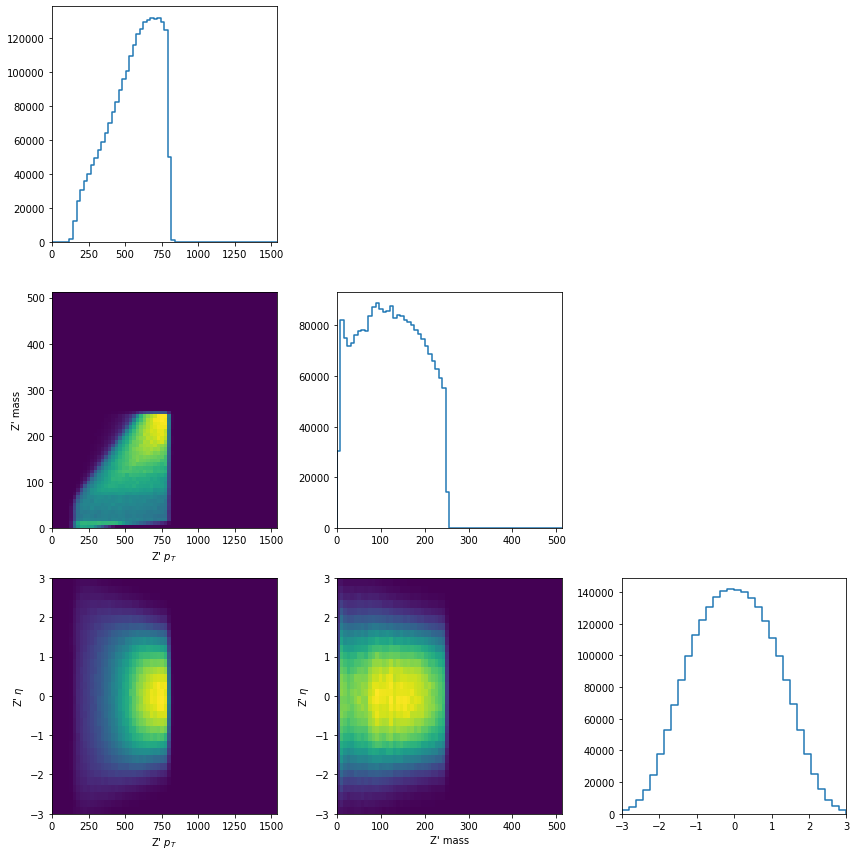

In [10]:
fig = splom(out["kin"])
fig.savefig("zprime_kinematics.pdf")

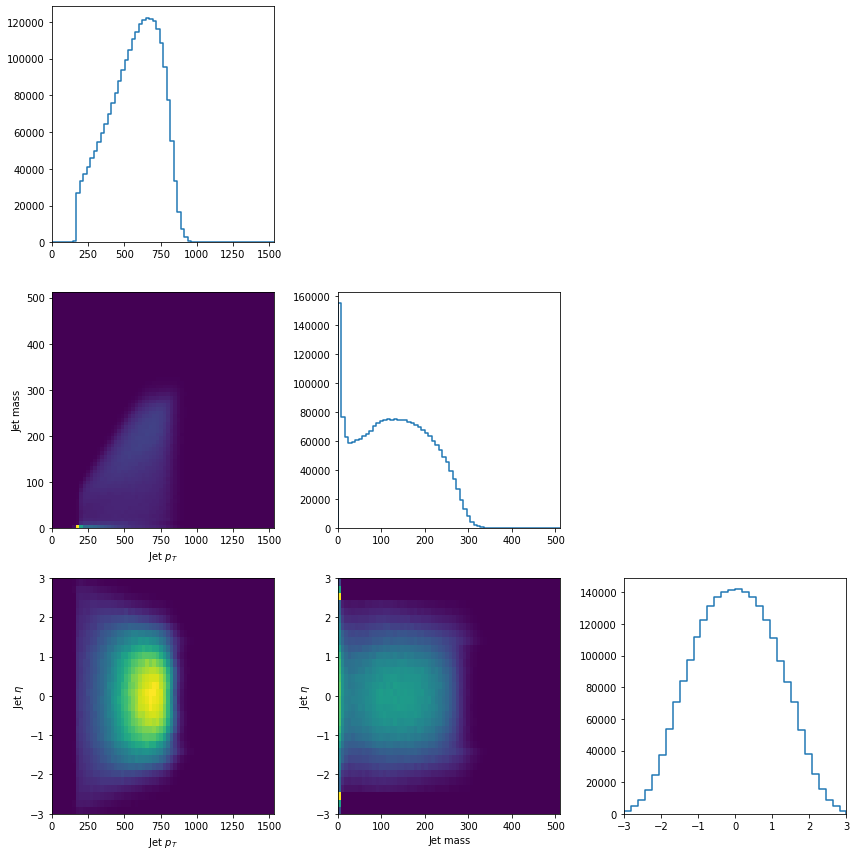

In [11]:
fig = splom(out["jetkin"])
fig.savefig("jet_kinematics.pdf")

/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


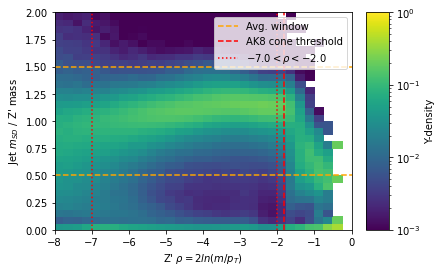

In [12]:
fig, ax = plt.subplots()

h = out["msd_qcdrho"][::sum, :, :]
H = h.counts()
h.view()[:] = H / H.sum(axis=1)[:, None]
art = h.plot(ax=ax, norm=LogNorm(vmin=1e-3, vmax=1))
art.cbar.set_label("Y-density")

window = slice(0.5j, 1.5j, sum)
ax.axhline(0.5, linestyle="--", color="orange", label="Avg. window")
ax.axhline(1.5, linestyle="--", color="orange")
ax.axvline(2*np.log(0.8/2), linestyle="--", color="red", label="AK8 cone threshold")
ax.axvline(-2.0, linestyle=":", color="red", label=r"$-7.0 < \rho < -2.0$")
ax.axvline(-7.0, linestyle=":", color="red")
ax.legend(loc="upper right")
fig.savefig("response_vs_rho.pdf")

In [13]:
from typing import List, Tuple
from scipy.optimize import lsq_linear
import correctionlib.schemav2 as clib


def ndpolyfit(
    points: List[np.ndarray],
    values: np.ndarray,
    weights: np.ndarray,
    varnames: List[str],
    degree: Tuple[int],
) -> clib.Formula:
    """Fit an n-dimensional polynomial to data points with weight

    Returns a correctionlib Formula node
    """
    if len(values.shape) != 1:
        raise ValueError("Expecting flat array of values")
    if not all(x.shape == values.shape for x in points):
        raise ValueError("Incompatible shapes for points and values")
    if values.shape != weights.shape:
        raise ValueError("Incompatible shapes for values and weights")
    if len(points) != len(varnames):
        raise ValueError("Dimension mismatch between points and varnames")
    if len(degree) != len(varnames):
        raise ValueError("Dimension mismatch between varnames and degree")
    if len(degree) > 4:
        raise NotImplementedError(
            "correctionlib Formula not available for more than 4 variables?"
        )
    degree = np.array(degree, dtype=int)
    npoints = len(values)
    powergrid = np.ones(shape=(npoints,) + tuple(degree + 1))
    for i, (x, deg) in enumerate(zip(points, degree)):
        shape = np.ones(1 + len(degree), dtype=int)
        shape[0] = npoints
        shape[i + 1] = deg + 1
        powergrid *= np.power.outer(x, np.arange(deg + 1)).reshape(shape)
    fit = lsq_linear(
        A=powergrid.reshape(npoints, -1) * weights[:, None],
        b=values * weights,
    )
    print(fit.message)
    dof = npoints - np.prod(degree + 1)
    prob = stats.chi2.sf(fit.cost, df=dof)
    print(f"chi2 = {fit.cost}, P({dof})dof = {prob:.3f}")
    params = fit.x.reshape(degree + 1)
    # TODO: n-dimensional Horner form
    expr = []
    for index in np.ndindex(tuple(degree + 1)):
        term = [str(params[index])] + [
            f"{var}^{p}" if p > 1 else var
            for var, p in zip("xyzt", index)
            if p > 0
        ]
        expr.append("*".join(term))
    return clib.Formula(
        nodetype="formula",
        expression="+".join(expr),
        parser="TFormula",
        variables=varnames,
    )


titles = {
    "msdraw": "FatJet Softdrop mass",
    "msdfjcorr": "PUPPI Corrections Applied",
    "msoftdrop": "NanoAODTools JERC Applied Softdrop Mass",
    "particleNet_mass": "ParticleNet regressed mass"
}
cset = clib.CorrectionSet(schema_version=2, corrections=[])

for mname, mdesc in titles.items():
    if mname == "particleNet_mass":
        continue
    msdhists = out[mname]
    # flavor, pt, mass, eta, msdratio
    hmreco = msdhists["mean"][::sum, :, :, :, window]
    hmtrue = msdhists["massmean"][::sum, :, :, :, window]

    ptgrid, massgrid, etagrid = np.meshgrid(*[ax.centers for ax in hmreco.axes], indexing="ij")
    msdgrid = hmreco.values()
    rgrid = msdgrid / ptgrid
    dgrid = np.log(ptgrid)

    mask = (hmreco.counts() > 5) & (rgrid < np.exp(-1.8/2)) # & (rgrid > np.exp(-6/2))
    msdcorr = np.ones_like(msdgrid)
    msdcorr[mask] = hmtrue.values()[mask] / hmreco.values()[mask]
    msdcorrw = np.zeros_like(msdgrid)
    msdcorrw[mask] = 1 / ( msdcorr[mask] * np.sqrt(hmreco.variances()[mask]) / hmreco.values()[mask] )

    print(f"=== {mname}")
    m2 = mask
    formula = ndpolyfit(
        points=[rgrid[m2], dgrid[m2], etagrid[m2]],
        values=msdcorr[m2],
        weights=msdcorrw[m2],
        varnames=["mdivpt", "logpt", "eta"],
        degree=(3, 2, 6),
    )
    cset.corrections.append(
        clib.Correction(
            name=mname + "_onebin",
            description=f"Correction to {mname} '{mdesc}' fit to polynomial",
            version=1,
            inputs=[
                clib.Variable(name="mdivpt", type="real", description="{mname} divided by jet pt"),
                clib.Variable(name="logpt", type="real", description="log(jet pt)"),
                clib.Variable(name="eta", type="real", description="jet eta"),
            ],
            output=clib.Variable(name="output", type="real", description=f"Multiplicative correction to {mname}"),
            data=formula,
        )
    )

    # equality in eta mask on purpose to help fits be continuous
    print(f"=== {mname} low eta")
    m2 = mask & (etagrid <= -1.44)
    formulalo = ndpolyfit(
        points=[rgrid[m2], dgrid[m2], etagrid[m2]],
        values=msdcorr[m2],
        weights=msdcorrw[m2],
        varnames=["mdivpt", "logpt", "eta"],
        degree=(2, 2, 2),
    )
    
    print(f"=== {mname} mid eta")
    m2 = mask & (etagrid >= -1.44) & (etagrid <= 1.44)
    formulamid = ndpolyfit(
        points=[rgrid[m2], dgrid[m2], etagrid[m2]],
        values=msdcorr[m2],
        weights=msdcorrw[m2],
        varnames=["mdivpt", "logpt", "eta"],
        degree=(3, 2, 4),
    )
    
    print(f"=== {mname} hi eta")
    m2 = mask & (etagrid >= 1.44)
    formulahi = ndpolyfit(
        points=[rgrid[m2], dgrid[m2], etagrid[m2]],
        values=msdcorr[m2],
        weights=msdcorrw[m2],
        varnames=["mdivpt", "logpt", "eta"],
        degree=(2, 2, 2),
    )
    
    cset.corrections.append(
        clib.Correction(
            name=mname,
            description=f"Correction to {mname} '{mdesc}' fit to polynomial in three eta bins",
            version=1,
            inputs=[
                clib.Variable(name="mdivpt", type="real", description=f"{mname} divided by jet pt"),
                clib.Variable(name="logpt", type="real", description="log(jet pt)"),
                clib.Variable(name="eta", type="real", description="jet eta"),
            ],
            output=clib.Variable(name="output", type="real", description=f"Multiplicative correction to {mname}"),
            data=clib.Binning(
                nodetype="binning",
                input="eta",
                edges=[-3, -1.44, 1.44, 3],
                content=[formulalo, formulamid, formulahi],
                flow="clamp",
            )
        )
    )

=== msdraw
The unconstrained solution is optimal.
chi2 = 59053.0516754031, P(80355)dof = 1.000
=== msdraw low eta
The unconstrained solution is optimal.
chi2 = 9839.941266375206, P(12865)dof = 1.000
=== msdraw mid eta
The unconstrained solution is optimal.
chi2 = 39020.72472342502, P(54519)dof = 1.000
=== msdraw hi eta
The unconstrained solution is optimal.
chi2 = 10384.402636591405, P(12941)dof = 1.000
=== msdfjcorr
The unconstrained solution is optimal.
chi2 = 63787.271668539586, P(77740)dof = 1.000
=== msdfjcorr low eta
The unconstrained solution is optimal.
chi2 = 8511.145589926215, P(11938)dof = 1.000
=== msdfjcorr mid eta
The unconstrained solution is optimal.
chi2 = 40468.3043593789, P(53798)dof = 1.000
=== msdfjcorr hi eta
The unconstrained solution is optimal.
chi2 = 9080.459280580573, P(11974)dof = 1.000
=== msoftdrop
The unconstrained solution is optimal.
chi2 = 59564.343131417656, P(80318)dof = 1.000
=== msoftdrop low eta
The unconstrained solution is optimal.
chi2 = 9759.2

In [14]:
 with open("msdcorr.json", "w") as fout:
     fout.write(cset.json(exclude_unset=True))
 cset = cset.to_evaluator()

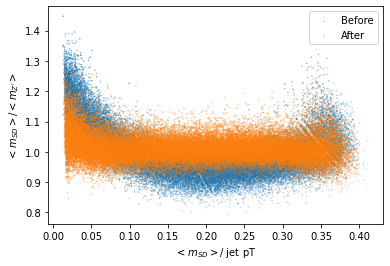

In [15]:
fig, ax = plt.subplots()

mname = "msoftdrop"
msdhists = out[mname]
title = titles[mname]

# flavor, pt, mass, eta, msdratio
hnum = msdhists["mean"][::sum, :, :, :, window]
hden = msdhists["massmean"][::sum, :, :, :, window]

mask = (hnum.counts() > 10)
msdgrid = np.where(mask, hnum.values(), massgrid)
msdcorr = np.ones_like(msdgrid)
msdcorr[mask] = hden.values()[mask] / hnum.values()[mask]
msdcorrw = np.zeros_like(msdgrid)
msdcorrw[mask] = 1 / ( msdcorr[mask] * np.sqrt(hnum.variances()[mask]) / hnum.values()[mask] )

x = rgrid
ax.scatter(
    x[mask],
    msdcorr[mask],
    s=1/msdcorrw[mask],
    label="Before",
)

if "cmean" in msdhists:
    hcnum = msdhists["cmean"][::sum, :, :, :, window]
    ax.scatter(
        x[mask],
        hden.values()[mask] / hcnum.values()[mask],
        s=1/msdcorrw[mask],
        label="After",
    )
ax.set_ylabel("$<m_{SD}> / <m_{Z'}>$")
ax.set_xlabel("$<m_{SD}> /$ jet pT")
ax.legend()
#fig.savefig("before_after.pdf")
fig.savefig("before_after_msdPT_2017.png")

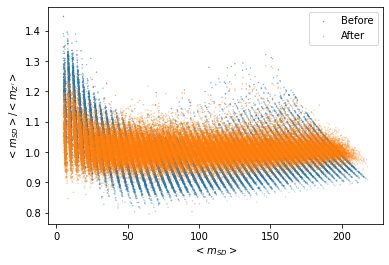

In [16]:
fig, ax = plt.subplots()

mname = "msoftdrop"
msdhists = out[mname]
title = titles[mname]

# flavor, pt, mass, eta, msdratio
hnum = msdhists["mean"][::sum, :, :, :, window]
hden = msdhists["massmean"][::sum, :, :, :, window]

mask = (hnum.counts() > 10)
msdgrid = np.where(mask, hnum.values(), massgrid)
msdcorr = np.ones_like(msdgrid)
msdcorr[mask] = hden.values()[mask] / hnum.values()[mask]
msdcorrw = np.zeros_like(msdgrid)
msdcorrw[mask] = 1 / ( msdcorr[mask] * np.sqrt(hnum.variances()[mask]) / hnum.values()[mask] )

x = msdgrid
ax.scatter(
    x[mask],
    msdcorr[mask],
    s=1/msdcorrw[mask],
    label="Before",
)

if "cmean" in msdhists:
    hcnum = msdhists["cmean"][::sum, :, :, :, window]
    ax.scatter(
        x[mask],
        hden.values()[mask] / hcnum.values()[mask],
        s=1/msdcorrw[mask],
        label="After",
    )
ax.set_ylabel("$<m_{SD}> / <m_{Z'}>$")
ax.set_xlabel("$<m_{SD}>$")
ax.legend()
#fig.savefig("before_after_sdm.pdf")
fig.savefig("before_after_sdm_2017.png")

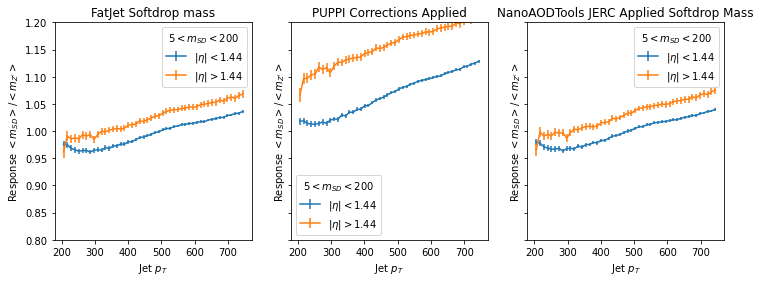

In [17]:
def plresp(hnum, hden, ax, **pl):
    resp = hnum.values() / hden.values()
    # denom is negligible
    resp_var = hnum.variances() / hden.values()**2
    eb = ax.errorbar(
        x=hnum.axes[0].centers,
        y=resp,
        yerr=np.sqrt(resp_var),
        **pl,
    )
    return eb


fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, facecolor="w")

for ax, (mname, title) in zip(axes, titles.items()):
    msdhists = out[mname]
    ax.set_title(title)

    # flavor, pt, mass, eta, msdratio
    hnum = msdhists["mean"][::sum, :, 10j:200j:sum, -1.44j:1.44j:sum, window]
    hden = msdhists["massmean"][::sum, :, 10j:200j:sum, -1.44j:1.44j:sum, window]
    plresp(hnum, hden, ax, label="$|\eta| < 1.44$")

    hnum = (
        msdhists["mean"][::sum, :, 10j:200j:sum, :-1.44j:sum, window]
        + msdhists["mean"][::sum, :, 10j:200j:sum, 1.44j::sum, window]
    )
    hden = (
        msdhists["massmean"][::sum, :, 10j:200j:sum, :-1.44j:sum, window]
        + msdhists["massmean"][::sum, :, 10j:200j:sum, 1.44j::sum, window]
    )
    plresp(hnum, hden, ax, label="$|\eta| > 1.44$")

    ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
    ax.set_xlabel(hnum.axes[0].label)
    ax.legend(title="$5 < m_{SD} < 200$")
    ax.set_ylim(0.8, 1.2)
    
fig.savefig("response_2017.png")
    

(0.9, 1.2)

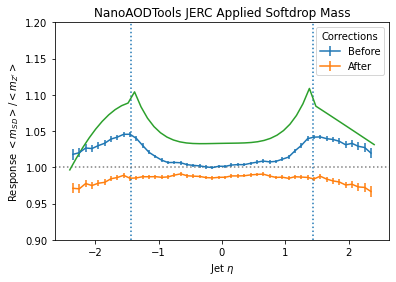

In [18]:
fig, ax = plt.subplots(facecolor="w")
mname = "msoftdrop"
msdhists = out[mname]
title = titles[mname]
ax.set_title(title)

pt, msd = slice(220j, 1000j, sum), slice(10j, 200j, sum)
# flavor, pt, mass, eta, msdratio
hden = msdhists["massmean"][::sum, pt, msd, :, window]

hnum = msdhists["mean"][::sum, pt, msd, :, window]
plresp(hnum, hden, ax, label="Before")

hnum = msdhists["cmean"][::sum, pt, msd, :, window]
plresp(hnum, hden, ax, label="After")

ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
ax.set_xlabel(hnum.axes[0].label)
ax.legend(title="Corrections")
ax.axvline(-1.44, linestyle=":")
ax.axvline(1.44, linestyle=":")
ax.axhline(1, linestyle=":", color="grey")

etas = np.linspace(-2.4, 2.4, 48)
ax.plot(etas, 1/MSDProc().corrs["msoftdrop"].evaluate(100/800, np.log(800), etas))

ax.set_ylim(0.9, 1.2)

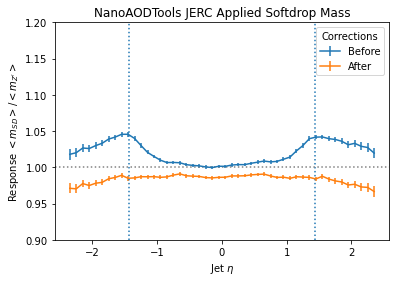

In [19]:
fig, ax = plt.subplots(facecolor="w")
mname = "msoftdrop"
msdhists = out[mname]
title = titles[mname]
ax.set_title(title)

pt, msd = slice(220j, 1000j, sum), slice(10j, 200j, sum)
# flavor, pt, mass, eta, msdratio
hden = msdhists["massmean"][::sum, pt, msd, :, window]

hnum = msdhists["mean"][::sum, pt, msd, :, window]
plresp(hnum, hden, ax, label="Before")

hnum = msdhists["cmean"][::sum, pt, msd, :, window]
plresp(hnum, hden, ax, label="After")

ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
ax.set_xlabel(hnum.axes[0].label)
ax.legend(title="Corrections")
ax.axvline(-1.44, linestyle=":")
ax.axvline(1.44, linestyle=":")
ax.axhline(1, linestyle=":", color="grey")

etas = np.linspace(-2.4, 2.4, 48)
#ax.plot(etas, 1/MSDProc().corrs["msoftdrop"].evaluate(100/800, np.log(800), etas))

ax.set_ylim(0.9, 1.2)
fig.savefig("Before_After_eta_jec_2017.png")

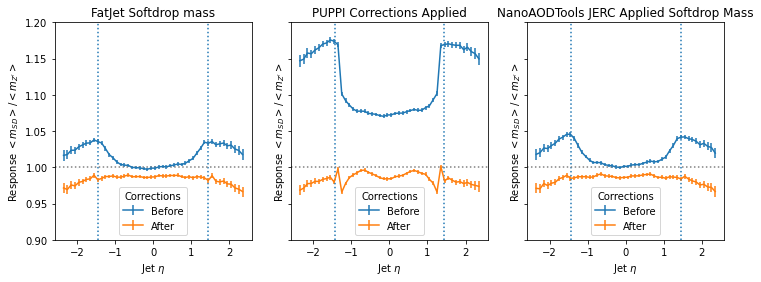

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, facecolor="w")

for ax, mname in zip(axes, titles):
    msdhists = out[mname]
    title = titles[mname]
    ax.set_title(title)
    
    ptwindow = slice(220j, 1000j, sum)
    masswindow = slice(10j, 200j, sum)

    # flavor, pt, mass, eta, msdratio
    hden = msdhists["massmean"][::sum, ptwindow, masswindow, :, window]

    hnum = msdhists["mean"][::sum, ptwindow, masswindow, :, window]
    plresp(hnum, hden, ax, label="Before")

    hnum = msdhists["cmean"][::sum, ptwindow, masswindow, :, window]
    plresp(hnum, hden, ax, label="After")

    ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
    ax.set_xlabel(hnum.axes[0].label)
    ax.legend(title="Corrections")
    ax.axvline(-1.44, linestyle=":")
    ax.axvline(1.44, linestyle=":")
    ax.axhline(1, linestyle=":", color="grey")
    ax.set_ylim(0.9, 1.2)
fig.savefig("Before_After_eta_2017.png")

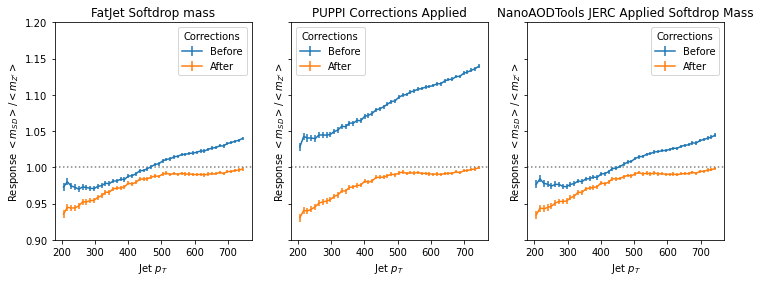

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, facecolor="w")

for ax, mname in zip(axes, titles):
    msdhists = out[mname]
    title = titles[mname]
    ax.set_title(title)
    
    ptwindow = slice(220j, 1000j, sum)
    masswindow = slice(10j, 200j, sum)

    # flavor, pt, mass, eta, msdratio
    hden = msdhists["massmean"][::sum, :, 10j:200j:sum, -2.4j:2.4j:sum, window]

    hnum = msdhists["mean"][::sum, :, 10j:200j:sum, -2.4j:2.4j:sum, window]
    plresp(hnum, hden, ax, label="Before")

    hnum = msdhists["cmean"][::sum, :, 10j:200j:sum, -2.4j:2.4j:sum, window]
    plresp(hnum, hden, ax, label="After")

    ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
    ax.set_xlabel(hnum.axes[0].label)
    ax.legend(title="Corrections")
    ax.axhline(1, linestyle=":", color="grey")
    ax.set_ylim(0.9, 1.2)
fig.savefig("Before_After_pt_2017.png")

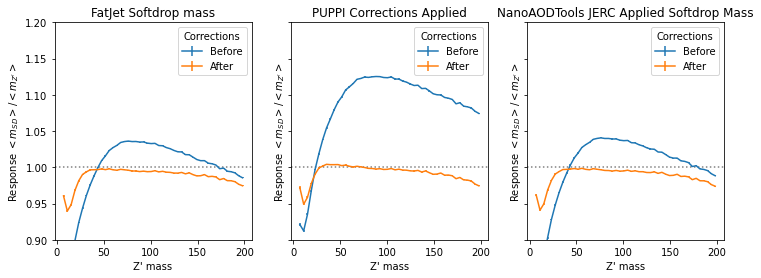

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, facecolor="w")

for ax, mname in zip(axes, titles):
    msdhists = out[mname]
    title = titles[mname]
    ax.set_title(title)
    
    ptwindow = slice(220j, 1000j, sum)
    masswindow = slice(10j, 200j, sum)

    # flavor, pt, mass, eta, msdratio
    hden = msdhists["massmean"][::sum, ptwindow, :, -2.4j:2.4j:sum, window]

    hnum = msdhists["mean"][::sum, ptwindow, :, -2.4j:2.4j:sum, window]
    plresp(hnum, hden, ax, label="Before")

    hnum = msdhists["cmean"][::sum, ptwindow, :, -2.4j:2.4j:sum, window]
    plresp(hnum, hden, ax, label="After")

    ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
    ax.set_xlabel(hnum.axes[0].label)
    ax.legend(title="Corrections")
    ax.axhline(1, linestyle=":", color="grey")
    ax.set_ylim(0.9, 1.2)
    fig.savefig("Before_After_zmass_2017.png")

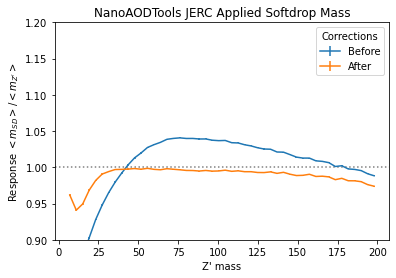

In [23]:
fig, ax = plt.subplots(facecolor="w")
mname = "msoftdrop"
msdhists = out[mname]
title = titles[mname]
ax.set_title(title)

ptwindow = slice(220j, 1000j, sum)
masswindow = slice(10j, 200j, sum)

# flavor, pt, mass, eta, msdratio
hden = msdhists["massmean"][::sum, ptwindow, :, -2.4j:2.4j:sum, window]

hnum = msdhists["mean"][::sum, ptwindow, :, -2.4j:2.4j:sum, window]
plresp(hnum, hden, ax, label="Before")

hnum = msdhists["cmean"][::sum, ptwindow, :, -2.4j:2.4j:sum, window]
plresp(hnum, hden, ax, label="After")

ax.set_ylabel("Response $<m_{SD}> / <m_{Z'}>$")
ax.set_xlabel(hnum.axes[0].label)
ax.legend(title="Corrections")
ax.axhline(1, linestyle=":", color="grey")
ax.set_ylim(0.9, 1.2)
fig.savefig("Before_After_zmass_jec_2017.png")

In [24]:
def addrhos(ax):
    ptval = np.linspace(0, 1024+512, 20)
    mval = 0.8 * ptval / 2
    ax.plot(ptval, mval, linestyle="--", color="r", label="AK8 cone")
    mval = np.exp(-2.0/2)*ptval
    ax.plot(ptval, mval, linestyle="--", color="k", label=r"$\rho=-2.0$")
    mval = np.exp(-7.0/2)*ptval
    ax.plot(ptval, mval, linestyle=":", color="k", label=r"$\rho=-7.0$")

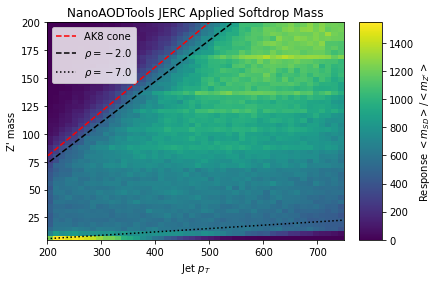

In [25]:
fig, ax = plt.subplots(facecolor="w")

ax.set_title(title)

# flavor, pt, mass, eta, msdratio
hnum = msdhists["mean"][::sum, :, :, ::sum, window]
hden = msdhists["massmean"][::sum, :, :, ::sum, window]

art = hist.Hist(
    *hnum.axes,
    data=hnum.counts(), #hnum.values() / hden.values(),
).plot(ax=ax)#, vmin=0.9, vmax=1.1)
art.cbar.set_label("Response $<m_{SD}> / <m_{Z'}>$")

addrhos(ax)
ax.legend(loc="upper left")

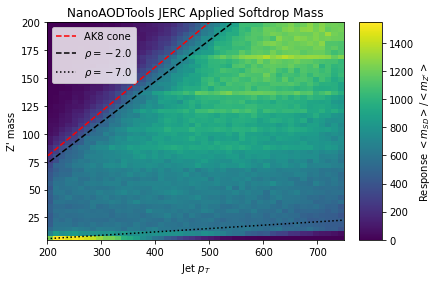

In [26]:
fig, ax = plt.subplots(facecolor="w")

ax.set_title(title)

# flavor, pt, mass, eta, msdratio
hnum = msdhists["mean"][::sum, :, :, ::sum, window]
hden = msdhists["massmean"][::sum, :, :, ::sum, window]

art = hist.Hist(
    *hnum.axes,
    data=hnum.counts(), #hnum.values() / hden.values(),
).plot(ax=ax)#, vmin=0.9, vmax=1.1)
art.cbar.set_label("Response $<m_{SD}> / <m_{Z'}>$")

addrhos(ax)
ax.legend(loc="upper left")

In [27]:
#fig, ax = plt.subplots(facecolor="w")

#mn = "particleNet_mass"
#ax.set_title(titles[mn])

# flavor, pt, mass, eta, msdratio
#hnum = out[mn]["mean"][::sum, :, :, ::sum, window]
#hden = out[mn]["massmean"][::sum, :, :, ::sum, window]
#ax.set_title(titles[mn])


#avg = hnum.sum().value / hden.sum().value
#art = hist.Hist(
#    *hnum.axes,
#    data=hnum.values() / hden.values(),
#).plot(ax=ax, cmap="bwr", vmin=0.8, vmax=1.2)
#art.cbar.set_label("Response $<m_{SD}> / <m_{Z'}>$" + f" (avg {avg:.2f})")
# art.cbar.set_label(f"Response diff (vs. unity)")

#addrhos(ax)

#ax.legend(loc="upper left")

In [28]:
#fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, facecolor="w")

#mn = "particleNet_mass"
#ax.set_title(titles[mn])

#fnames = {0: "light jets", 1: "c jets", 2: "b jets"}

#for i, (ax, flavor) in enumerate(zip(axes, fnames)):
#    hnumf = out[mn]["mean"][flavor, :, :, ::sum, window]
#    hdenf = out[mn]["massmean"][flavor, :, :, ::sum, window]
#    ax.set_title(titles[mn] + ", " + fnames[flavor])

#    avg = hnumf.sum().value / hdenf.sum().value
#    art = hist.Hist(
#        *hnum.axes,
#        data=hnumf.values() / hdenf.values(),
#    ).plot(ax=ax, cmap="bwr", vmin=0.8, vmax=1.2, cbar=False if i < 2 else True)
#    if i == 2:
#        art.cbar.set_label("Response $<m_{SD}> / <m_{Z'}>$")


#    addrhos(ax)
#    ax.legend(loc="upper left")

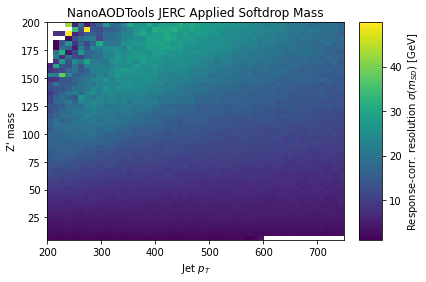

In [29]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

fig, ax = plt.subplots(facecolor="w")

mn = "msoftdrop"
ax.set_title(titles[mn])

# flavor, pt, mass, eta, msdratio
hmean = out[mn]["cmean"][::sum, :, :, ::sum, window]

art = hist.Hist(
    *hmean.axes,
    data=err(hmean),
).plot(ax=ax, cmin=0, cmax=50)
art.cbar.set_label("Response-corr. resolution $\sigma(m_{SD})$ [GeV]")

/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


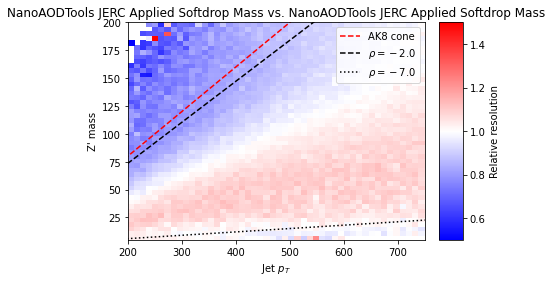

In [30]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

fig, ax = plt.subplots(facecolor="w")

mn2 = "msoftdrop"
#mn2 = "msoftdrop"
# mn2 = "msdraw"
# mn2 = "particleNet_mass"
ax.set_title(titles[mn2] + " vs. " + titles[mn])

# flavor, pt, mass, eta, msdratio
hmean2 = out[mn2]["mean"][::sum, :, :, ::sum, window]

art = hist.Hist(
    *hmean.axes,
    data=(err(hmean2) / err(hmean)) * (hmean.values() / hmean2.values()),
).plot(ax=ax, cmap="bwr", vmin=0.5, vmax=1.5)
art.cbar.set_label("Relative resolution")

addrhos(ax)
ax.legend()

/users/h2/akobert/coffea/my_env/lib64/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


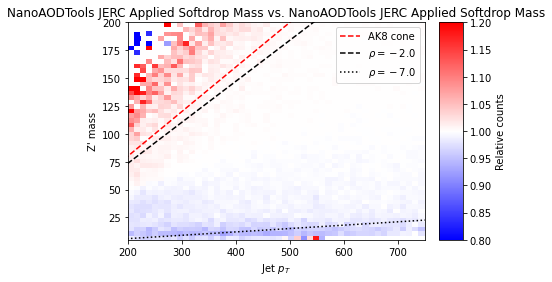

In [31]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

fig, ax = plt.subplots(facecolor="w")

# mn2 = "msdfjcorr"
mn2 = "msoftdrop"
#3mn2 = "msdraw"
#mn2 = "particleNet_mass"
ax.set_title(titles[mn2] + " vs. " + titles[mn])

# flavor, pt, mass, eta, msdratio
hmean2 = out[mn2]["mean"][::sum, :, :, ::sum, window]

art = hist.Hist(
    *hmean.axes,
    data=hmean2.counts() / hmean.counts(),
).plot(ax=ax, cmap="bwr", vmin=0.8, vmax=1.2)
art.cbar.set_label("Relative counts")

addrhos(ax)
ax.legend()